# Dynamical modeling from time-series multiomics data using machine learning

* Main paper: [Costello & Martin, Nature 2018](https://www.nature.com/articles/s41540-018-0054-3)
* Dataset: https://doi.org/10.1016/j.cels.2016.04.004

This notebook serves as a helper for development.

In [1]:
from bioLearningPractical.generateTSDataSet import *
from bioLearningPractical.integrator import *
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pickle
import sys
import argparse
import os

parser = argparse.ArgumentParser(description='ML for kinetic modeling')
parser.add_argument('--intermediates', default="./data/processed/", metavar='DIR',
                    help='path to store processed intermediate data')
parser.add_argument('--result', metavar='DIR',
                    help='path to store the results')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of workers for model training')
parser.add_argument('--pathway', default=1, type=int,
                    help='Isopentenol producing (0) or Limonene producing (1) pathway')
parser.add_argument('--num_points', default=100, type=int,
                    help='number of data points to interpolate')
parser.add_argument('--dataroot', default='./data',
                    help='path where raw data is stored')
parser.add_argument('--model', default='./model', type=str, metavar='PATH',
                    help='path to the trained model')

parser.add_argument('--epochs', default=100000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float,
                    metavar='momentum', help='momentum')
parser.add_argument('--weight_decay', '--wd', default=0.0001, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--log_train_dir', default='log_train', type=str,
                    help='log for train')
parser.add_argument('--log_test_dir', default='log_test', type=str,
                    help='log for test')

global args
args = parser.parse_args("--dataroot ./data".split())

We focus here on limonene, so make sure to set the correct pathway setting.

In [2]:
data_dir = os.path.abspath(args.intermediates)

if args.pathway == 0: # use isopentenol-producing pathway
    pathway = 'isopentenol'
    strains, training_strains, test_strains = ['I1','I2','I3'], ['I1', 'I3'], ['I2']
    targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']
    features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                        'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']
elif args.pathway == 1: # use limonene-producing pathway
    pathway = 'limonene'
    strains, training_strains, test_strains = ['L1','L2','L3'], ['L1','L3'], ['L2']
    targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']
    features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

# Data Preprocessing

Outline:
- read metabolite and protein tables
- handles missing values
- selects relevant strains
- pivots the relevant proteins
- combines metabolite and protein tables
- saves to disk
- computes time-series data and derivatives

In [3]:
metabolite_file_name = os.path.join(args.dataroot, 'time_series_metabolomics.csv')

outputs = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

mdf = pd.read_csv(metabolite_file_name)
print(mdf.shape)
mdf = mdf.loc[mdf['Strain'].isin(strains)]
display(mdf[['Strain', 'Hour'] + targets])

(126, 91)


,Strain,Hour,Acetyl-CoA (uM),HMG-CoA (uM),Intracellular Mevalonate (uM),Mev-P (uM),IPP/DMAPP (uM),Limonene g/L
70,L1,0,0.386459,0.002562,0.003715,0.000000,0.071364,0.000000
71,L1,2,NaN,NaN,NaN,NaN,NaN,NaN
72,L1,4,0.815275,0.203158,0.161369,0.516691,0.721004,0.002417
73,L1,6,NaN,NaN,NaN,NaN,NaN,NaN
74,L1,8,NaN,NaN,0.170785,0.756921,1.491663,0.007934
75,L1,10,NaN,NaN,NaN,NaN,NaN,NaN
76,L1,12,0.488733,0.231160,0.168154,0.804748,1.508219,0.014846
77,L1,16,NaN,NaN,NaN,NaN,NaN,NaN
78,L1,18,0.317210,0.190574,0.142823,2.333130,2.774149,0.018471
79,L1,20,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# now we must interpolate missing values
mdf = mdf.reset_index()
mdf = mdf.interpolate(method ='linear', limit_direction ='forward')
mdf = mdf[['Strain','Hour'] + outputs].pivot_table(mdf[['Strain','Hour'] + outputs],index=['Strain','Hour'],aggfunc=np.sum)
display(mdf[targets])

Acetyl-CoA (uM)  HMG-CoA (uM)  Intracellular Mevalonate (uM)  \
Strain Hour                                                                 
L1     0            0.386459      0.002562                       0.003715   
       2            0.600867      0.102860                       0.082542   
       4            0.815275      0.203158                       0.161369   
       6            0.733639      0.210158                       0.166077   
       8            0.652004      0.217159                       0.170785   
       10           0.570369      0.224159                       0.169469   
       12           0.488733      0.231160                       0.168154   
       16           0.402971      0.210867                       0.155489   
       18           0.317210      0.190574                       0.142823   
       20           0.277733      0.189813                       0.161614   
       24           0.238256      0.189051                       0.180405   
       36           0.158098      0.148541                       0.089452   
       48           0.077939      0.108031                       0.068482   
       72           0.182149      0.057830                       0.069763   
L2     0            0.286359      0.007628                       0.892763   
       2            0.314098      0.024570                       1.772122   
       4            0.341838      0.041512                       2.651481   
       6            0.316095      0.045943                       2.969243   
       8            0.290352      0.050373                       3.287004   
       10           0.264609      0.054803                       3.687173   
       12           0.238866      0.059233                       4.087343   
       16           0.212017      0.049501                       3.722331   
       18           0.185168      0.039769                       3.357319   
       20           0.163885      0.030129                       3.975827   
       24           0.142602      0.020489                       4.594335   
       36           0.112074      0.013672                       5.166683   
       48           0.081545      0.006856                       4.371739   
       72           0.164040      0.004976                       5.462721   
L3     0            0.246535      0.003096                       0.036670   
       2            0.301730      0.006188                       0.368531   
       4            0.356924      0.009279                       0.700392   
       6            0.361576      0.010647                       0.774576   
       8            0.366228      0.012015                       0.848760   
       10           0.370879      0.013382                       0.896955   
       12           0.375531      0.014750                       0.945150   
       16           0.397997      0.011864                       0.968477   
       18           0.420463      0.008978                       0.991804   
       20           0.333603      0.009342                       1.244933   
       24           0.246743      0.009705                       1.498061   
       36           0.205029      0.004853                       0.931822   
       48           0.163314      0.000000                       1.213345   
       72           0.163314      0.000000                       1.369915   

             Mev-P (uM)  IPP/DMAPP (uM)  Limonene g/L  
Strain Hour                                            
L1     0       0.000000        0.071364      0.000000  
       2       0.258346        0.396184      0.001209  
       4       0.516691        0.721004      0.002417  
       6       0.636806        1.106333      0.005176  
       8       0.756921        1.491663      0.007934  
       10      0.780834        1.499941      0.011390  
       12      0.804748        1.508219      0.014846  
       16      1.568939        2.141184      0.016658  
       18      2.333130        2.774149      0.018471  
       2

Text(0.5,0.98,'Limonene Strain: Missing Data Interpolated')

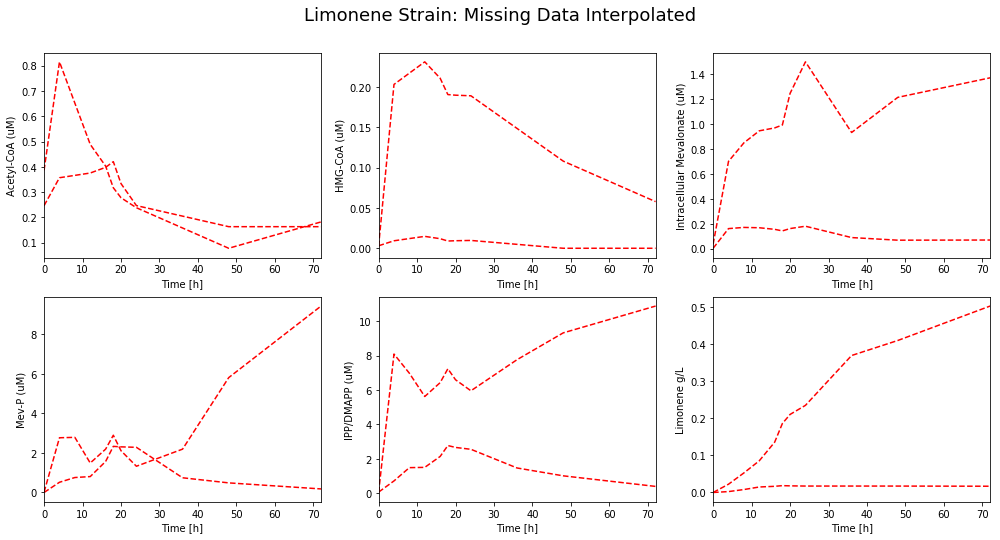

In [5]:
plt.figure(figsize=(14, 8))
for i, target in enumerate(targets):
    plt.subplot(2, 3, i + 1)
    for strain in training_strains:
        strain_df = mdf.loc[(strain,slice(None))]
        
        # handle missing data
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        #X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
        #trainInterpFun = interp1d(X,y) #create an interpolation function
        #actual_data = savgol_filter(trainInterpFun(times), 7, 2)
        train_line, = plt.plot(X, y,'r--')
    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Limonene Strain: Missing Data Interpolated', fontsize=18)

Compare this to the figure in the paper:

![limonene_figure](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41540-018-0054-3/MediaObjects/41540_2018_54_Fig6_HTML.gif?as=webp)

Source: see link in notebook markdown. License: Creative Commons 4.0

In [6]:
# Now let's do the same for protein data
protein_file_name = os.path.join(args.dataroot, 'time_series_proteomics.csv')
pdf = pd.read_csv(protein_file_name)

pdf = pdf.loc[pdf['Strain'].isin(strains)]
pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
#pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)
pdf['Hour'] = pdf['Hour'].astype('float32')
print(pdf['Protein'].unique())
display(pdf)

['AtoB' 'Bisabolene' 'HMGR' 'HMGS' 'Idi' 'IspA' 'Limonene Synthase' 'MK'
 'NudB' 'PMD' 'PMK' '6PGD' 'FRDA' 'CAPP' 'LACI' 'FUMC' 'K6PF2' 'DHSB'
 'FDHF' 'IDH' 'PFLB' 'ACKA' 'ENO' 'G6PI' 'K6PF1' 'PGK' 'RPIA' 'SUCC'
 'TPIS' 'TALA' 'TALB' 'FRDC' 'FRDD' 'F16PA' 'G3P1' 'GLPX' 'PTA' 'DLDH'
 'ADHE' 'HYCB' 'ALF' 'CISY' 'FUMA' 'DHSA' 'DHSD' 'FRDB' 'G6PD' 'KPYK1'
 'ODO1' 'ODO2' 'SUCD' 'HYCC' 'HYCD' 'HYCE' 'HYCF' 'HYCG' 'GLPX2' 'KPYK2'
 'YBHA' 'PCKA' 'PPSA' 'ACON1' 'MAO1' 'TKT1' 'ACSA' 'TKT2' 'MQO' 'ACON2'
 'RPIB' 'GPMI' 'MDH' 'GPMA' 'DHSC' 'MAO2' 'EUTD' 'GPPS' 'AMPR' 'Cam' 'BSA']


,Sample Name,Hour,Organism,Strain,Replicate,Protein,Protein name,Pathway,Peptide,PeptideArea,...,PeptideCorrectedArea Normalized to BSA,ProteinArea,ProteinArea Normalized to AmpR,ProteinArea Normalized to Cam,ProteinArea Normalized to BSA,PrecursorMz,PrecursorCharge,RetentionTime,Background,PeakRank
7550,51,0.0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,LGDGQVYDVILR,6177.0,...,0.020394,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7551,51,0.0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,TFVFSQDEFPK,2032.0,...,0.006709,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7552,51,0.0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,ASQLAFPGENILDEAK,2595.0,...,0.008568,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7553,51,0.0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,YNVSPAIFDNFK,1298.0,...,0.004286,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7554,51,0.0,Saccharomyces cerevisiae,L1,51,HMGR,NaN,Mevalonate Pathway,SDVSALVELNIAK,23223.0,...,0.075007,30588.0,0.1709,0.1079,0.1010,0,0,0,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11924,79,72.0,NaN,L3,79,AMPR,NaN,Antibiotic Marker,SALPAGWFIADK,171979.0,...,0.544081,141092.0,1.0000,0.3847,0.4473,0,0,0,346,0
11925,79,72.0,NaN,L3,79,AMPR,NaN,Antibiotic Marker,VGYIELDLNSGK,113026.0,...,0.350449,141092.0,1.0000,0.3847,0.4473,0,0,0,2475,0
11926,79,72.0,NaN,L3,79,Cam,NaN,Antibiotic Marker,FYPAFIHILAR,426382.0,...,1.351641,366798.0,2.5997,1.0000,1.1628,0,0,0,0,0
11927,79,72.0,NaN,L3,79,Cam,NaN,Antibiotic Marker,ITGYTTVDISQWHR,308652.0,...,0.973876,366798.0,2.5997,1.0000,1.1628,0,0,0,1438,0


In [7]:
# we want to get a time series from 'Protein' column

proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB'] # relevant proteins
proteins = [('ProteinArea',protein) for protein in proteins]
columns = ['Strain','Hour','Protein','ProteinArea']
pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Hour'],columns='Protein',aggfunc=np.sum)
pdf = pdf[proteins]
pdf.columns = pdf.columns.get_level_values(1)
display(pdf)

Protein            AtoB       HMGR        HMGS         MK        PMD  \
Strain Hour                                                            
L1     0.0       8209.0    68464.0     29238.0    19532.0   349263.0   
       4.0    1484471.0   223652.0    492929.0    50037.0   557136.0   
       8.0    1614585.0   204481.0    483006.0    51045.0   656509.0   
       12.0   1560691.0   181504.0    474976.0    53706.0   692486.0   
       18.0   1937084.0   218177.0    590173.0    66428.0   842557.0   
       24.0   1477381.0   177012.0    483653.0    53693.0   668706.0   
       36.0   1772569.0   184872.0    501223.0    55784.0   797741.0   
       48.0   1653221.0   175501.0    467626.0    54921.0   719763.0   
       72.0   1302122.0   143055.0    451549.0    51173.0   710718.0   
L2     0.0    1268050.0   975303.0   1814537.0    66644.0   222086.0   
       4.0   11694977.0  5552278.0  12874533.0   856518.0  1120042.0   
       8.0   20400000.0  8593167.0  23209717.0  1595060.0  2920532.0   
       12.0  20400000.0  7944106.0  22010089.0  1656186.0  3014555.0   
       18.0  17725856.0  6821902.0  18686861.0  1654815.0  3312130.0   
       24.0  20000000.0  6527289.0  18827893.0  1704014.0  3419861.0   
       36.0  18090900.0  5140768.0  15830407.0  1552782.0  3320835.0   
       48.0  17057570.0  4649280.0  13606759.0  1494543.0  3229677.0   
       72.0  15361209.0  4145041.0  10316009.0  1288346.0  2835588.0   
L3     0.0      50439.0   122581.0     76314.0    27218.0    92311.0   
       4.0    1243475.0   357869.0    792739.0   834097.0  1889751.0   
       8.0    1637580.0   441403.0   1025023.0  1111356.0  2881791.0   
       12.0   1751133.0   497937.0   1041544.0  1430725.0  3343904.0   
       18.0   1588690.0   435496.0    966447.0  1579868.0  3835400.0   
       24.0   1714324.0   455960.0   1032127.0  1872053.0  4266870.0   
       36.0   1651317.0   457905.0   1079484.0  2057900.0  4686725.0   
       48.0   1783767.0   461828.0   1086167.0  2168842.0  4928542.0   
       72.0   1651169.0   411109.0    981081.0  1919306.0  4782684.0   

Protein            PMK        Idi        GPPS  Limonene Synthase     NudB  
Strain Hour                                                                
L1     0.0     78129.0   678723.0      7934.0           233080.0  10827.0  
       4.0     32024.0   882715.0   1279279.0         14184519.0  48234.0  
       8.0     19615.0   995526.0   1242422.0         14914904.0  43116.0  
       12.0    19545.0   934538.0   1205546.0         13691535.0  40161.0  
       18.0    18964.0  1233368.0   1609621.0         16143199.0  59525.0  
       24.0    16031.0   885615.0   1279718.0         13275815.0  35031.0  
       36.0    23131.0  1025149.0   1270380.0         15309986.0  49631.0  
       48.0    16436.0   899851.0   1133490.0         13183372.0  40397.0  
       72.0    18571.0   875530.0    936997.0         12169879.0  29451.0  
L2     0.0     38871.0   992709.0    238334.0          1016183.0  13853.0  
       4.0    780656.0  1562460.0  11734492.0         15152786.0  35169.0  
       8.0   1230925.0  2730791.0  18687520.0         25800000.0  58942.0  
       12.0  1747295.0  2283673.0  15128321.0         21800000.0  51299.0  
       18.0  1897376.0  2084517.0  13543911.0         20800000.0  41562.0  
       24.0  2212389.0  2511286.0  15171025.0         19586312.0  53747.0  
       36.0  2094512.0  2200888.0  14993057.0         19665648.0  52512.0  
       48.0  2350300.0  1973428.0  17127800.0         20800000.0  47867.0  
       72.0  2454097.0  1670806.0  18437344.0         21400000.0  54072.0  
L3     0.0    211927.0   325994.0    297412.0           319950.0   4126.0  
       4.0    588087.0  2778685.0   4043845.0         11680415.0  31528.0  
       8.0    750621.0  3357679.0   3753584.0         13418025.0   9948.0  
       12.0   959681.0  3922590.0   3156798.0         14887581.0  47360.0  
       18.0  1043792.0  3962489.0   2710574.0         15278968.0  44980.0  
       24.0

Now combine protein and metabolite tables and save to disk.

In [8]:
all_df = pd.concat([pdf, mdf], axis=1)
all_df = all_df.interpolate(method ='linear', limit_direction ='forward')
train_df = all_df.loc[(training_strains,slice(None))]
test_df = all_df.loc[(test_strains,slice(None))]

display(train_df)

# save processed files to disk
train_df.to_pickle(os.path.join(data_dir, 'train_' + pathway + '.pkl'))
test_df.to_pickle(os.path.join(data_dir, 'test_' + pathway + '.pkl'))

AtoB      HMGR       HMGS         MK        PMD        PMK  \
Strain Hour                                                                    
L1     0.0      8209.0   68464.0    29238.0    19532.0   349263.0    78129.0   
       2.0    746340.0  146058.0   261083.5    34784.5   453199.5    55076.5   
       4.0   1484471.0  223652.0   492929.0    50037.0   557136.0    32024.0   
       6.0   1549528.0  214066.5   487967.5    50541.0   606822.5    25819.5   
       8.0   1614585.0  204481.0   483006.0    51045.0   656509.0    19615.0   
       10.0  1587638.0  192992.5   478991.0    52375.5   674497.5    19580.0   
       12.0  1560691.0  181504.0   474976.0    53706.0   692486.0    19545.0   
       16.0  1748887.5  199840.5   532574.5    60067.0   767521.5    19254.5   
       18.0  1937084.0  218177.0   590173.0    66428.0   842557.0    18964.0   
       20.0  1707232.5  197594.5   536913.0    60060.5   755631.5    17497.5   
       24.0  1477381.0  177012.0   483653.0    53693.0   668706.0    16031.0   
       36.0  1772569.0  184872.0   501223.0    55784.0   797741.0    23131.0   
       48.0  1653221.0  175501.0   467626.0    54921.0   719763.0    16436.0   
       72.0  1302122.0  143055.0   451549.0    51173.0   710718.0    18571.0   
L3     0.0     50439.0  122581.0    76314.0    27218.0    92311.0   211927.0   
       2.0    646957.0  240225.0   434526.5   430657.5   991031.0   400007.0   
       4.0   1243475.0  357869.0   792739.0   834097.0  1889751.0   588087.0   
       6.0   1440527.5  399636.0   908881.0   972726.5  2385771.0   669354.0   
       8.0   1637580.0  441403.0  1025023.0  1111356.0  2881791.0   750621.0   
       10.0  1694356.5  469670.0  1033283.5  1271040.5  3112847.5   855151.0   
       12.0  1751133.0  497937.0  1041544.0  1430725.0  3343904.0   959681.0   
       16.0  1669911.5  466716.5  1003995.5  1505296.5  3589652.0  1001736.5   
       18.0  1588690.0  435496.0   966447.0  1579868.0  3835400.0  1043792.0   
       20.0  1651507.0  445728.0   999287.0  1725960.5  4051135.0  1105793.5   
       24.0  1714324.0  455960.0  1032127.0  1872053.0  4266870.0  1167795.0   
       36.0  1651317.0  457905.0  1079484.0  2057900.0  4686725.0  1309697.0   
       48.0  1783767.0  461828.0  1086167.0  2168842.0  4928542.0  1408951.0   
       72.0  1651169.0  411109.0   981081.0  1919306.0  4782684.0  1234621.0   

                   Idi       GPPS  Limonene Synthase     NudB  ...  \
Strain Hour                                                    ...   
L1     0.0    678723.0     7934.0           233080.0  10827.0  ...   
       2.0    780719.0   643606.5          7208799.5  29530.5  ...   
       4.0    882715.0  1279279.0         14184519.0  48234.0  ...   
       6.0    939120.5  1260850.5         14549711.5  45675.0  ...   
       8.0    995526.0  1242422.0         14914904.0  43116.0  ...   
       10.0   965032.0  1223984.0         14303219.5  41638.5  ...   
       12.0   934538.0  1205546.0         13691535.0  40161.0  ...   
       16.0  1083953.0  1407583.5         14917367.0  49843.0  ...   
       18.0  1233368.0  1609621.0         16143199.0  59525.0  ...   
       20.0  1059491.5  1444669.5         14709507.0  47278.0  ...   
       24.0   885615.0  1279718.0         13275815.0  35031.0  ...   
       36.0  1025149.0  1270380.0         15309986.0  49631.0  ...   
       48.0   899851.0  1133490.0         13183372.0  40397.0  ...   
       72.0   875530.0   936997.0         12169879.0  29451.0  ...   
L3     0.0    325994.0   297412.0           319950.0   4126.0  ...   
       2.0   1552339.5  2170628.5          6000182.5  17827.0  ...   
       4.0   2778685.0  4043845.0         11680415.0  31528.0  ...   
       6.0   3068182.0  3898714.5         12549220.0  20738.0  ...   
       8.0   3357679.0  3753584.0         13418025.0   9948.0  ...   
       10.0  3640134.5  3455191.0         14152803.0  28654.0  ...   
       12.0  3922590.0  3156798.0         14887581.0  47360.0  ...   
       

In [9]:
# generate time series data

train_tsdf = generateTSDataSet(train_df, features, targets, n_points=args.num_points)
train_tsdf.to_pickle(os.path.join(data_dir, 'tsdf_' + pathway + '.pkl'))

test_tsdf = generateTSDataSet(test_df, features, targets, n_points=args.num_points)
display(test_tsdf)

#additionally split data for COPASI
if args.pathway == 1:
    X = test_tsdf['feature'].loc['L2']
    print(X.columns)
    X.reset_index().to_csv(os.path.join(data_dir, 'L2.csv'), index=False)

Total Time Series in Data Set:  2
Total Time Series in Data Set:  1


feature                                            \
                     OD600  ATP (uM)          AtoB Limonene Synthase   
Strain Time (h)                                                        
L2     0.000000   0.707405  0.304090  1.249415e+06      9.784190e+05   
       0.727273   0.989084  0.279997  3.175036e+06      3.609133e+06   
       1.454545   1.265169  0.257041  5.082022e+06      6.202083e+06   
       2.181818   1.535658  0.235223  6.970373e+06      8.757269e+06   
       2.909091   1.810623  0.212495  8.873632e+06      1.134267e+07   
...                    ...       ...           ...               ...   
       69.090909  3.788182  0.212410  1.556683e+07      2.132727e+07   
       69.818182  3.793636  0.216252  1.551542e+07      2.134545e+07   
       70.545455  3.799091  0.220094  1.546402e+07      2.136364e+07   
       71.272727  3.804545  0.223937  1.541261e+07      2.138182e+07   
       72.000000  3.810000  0.227779  1.536121e+07      2.140000e+07   

                                                                          \
                          HMGR          HMGS            MK           PMK   
Strain Time (h)                                                            
L2     0.000000   9.586787e+05  1.806693e+06  6.608846e+04  3.571606e+04   
       0.727273   1.817455e+06  3.830152e+06  2.105908e+05  1.756340e+05   
       1.454545   2.659607e+06  5.845767e+06  3.545376e+05  3.123969e+05   
       2.181818   3.485134e+06  7.853538e+06  4.979288e+05  4.460049e+05   
       2.909091   4.323961e+06  9.867584e+06  6.417645e+05  5.821369e+05   
...                        ...           ...           ...           ...   
       69.090909  4.206161e+06  1.071489e+07  1.313340e+06  2.441516e+06   
       69.818182  4.190881e+06  1.061517e+07  1.307091e+06  2.444661e+06   
       70.545455  4.175601e+06  1.051545e+07  1.300843e+06  2.447806e+06   
       71.272727  4.160321e+06  1.041573e+07  1.294594e+06  2.450952e+06   
       72.000000  4.145041e+06  1.031601e+07  1.288346e+06  2.454097e+06   

                                          ...                    target  \
                           PMD  GPP (uM)  ... HMG-CoA (uM) HMG-CoA (uM)   
Strain Time (h)                           ...                             
L2     0.000000   2.318537e+05  0.008534  ...     0.007358     0.009158   
       0.727273   3.794901e+05  0.015908  ...     0.013952     0.008970   
       1.454545   5.368942e+05  0.023576  ...     0.020275     0.008594   
       2.181818   7.040660e+05  0.031540  ...     0.026327     0.008557   
       2.909091   8.634237e+05  0.039267  ...     0.032596     0.008030   
...                        ...       ...  ...          ...          ...   
       69.090909  2.883356e+06  0.020633  ...     0.005204    -0.000079   
       69.818182  2.871414e+06  0.019742  ...     0.005147    -0.000079   
       70.545455  2.859472e+06  0.018851  ...     0.005090    -0.000079   
       71.272727  2.847530e+06  0.017960  ...     0.005033    -0.000079   
       72.000000  2.835588e+06  0.017068  ...     0.004976    -0.000079   

                                       feature                        target  \
                 Intracellular Mevalonate (uM) Intracellular Mevalonate (uM)   
Strain Time (h)                                                                
L2     0.000000                       0.880607                      0.471134   
       0.727273                       1.219823                      0.462692   
       1.454545                       1.546884                      0.445809   
       2.181818                       1.861788                      0.444121   
       2.909091                       2.186418                      0.420485   
...                                        ...                           ...   
       69.090909                      5.330480                      0.045917   
       69.818182                      5.363540                      0.045917   
       70.5454

Index(['OD600', 'ATP (uM)', 'AtoB', 'Limonene Synthase', 'HMGR', 'HMGS', 'MK',
       'PMK', 'PMD', 'GPP (uM)', 'NAD (uM)', 'NADP (uM)', 'Acetate g/L',
       'Pyruvate g/L', 'citrate (uM)', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)',
       'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)',
       'Limonene g/L'],
      dtype='object')


# Model Training

Outline:
- use random forest to train $f(x)$
- solve the IVP with Runge-Kutta 45
- define the kinetic model
- optimize kinetic parameters
- solve IVP with kinetic model and compare to ML

In [10]:
specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','Limonene Synthase','Limonene g/L'],
                             'Limonene g/L':['OD600','ATP (uM)','Limonene Synthase','Limonene g/L','GPP (uM)']}

In [11]:
mlmodel = RandomForestRegressor(n_estimators=20)
modelDict = {}

average_training_score = 0
n = 0
for target_index in train_tsdf.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print("Processing target: ", target)

    X = train_tsdf['feature'][specific_features[target]].values.tolist()
    y = train_tsdf[target_index].values.tolist()
    
    modelDict[target] = clone(mlmodel)
    modelDict[target] = modelDict[target].fit(X,y)
    
    score = modelDict[target].score(X,y)
    print('Cross Validated Pearson R: {:f}'.format(score))
    average_training_score +=  score
    
average_training_score /= n
print('Average Training Score:',average_training_score)

Processing target:  Acetyl-CoA (uM)
Cross Validated Pearson R: 0.976360
Processing target:  HMG-CoA (uM)
Cross Validated Pearson R: 0.928606
Processing target:  Intracellular Mevalonate (uM)
Cross Validated Pearson R: 0.972627
Processing target:  Mev-P (uM)
Cross Validated Pearson R: 0.956729
Processing target:  IPP/DMAPP (uM)
Cross Validated Pearson R: 0.935532
Processing target:  Limonene g/L
Cross Validated Pearson R: 0.988829
Average Training Score: 0.9597804257364314


In [12]:
def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    
    """
    Kinetic model for the Limonene pathway.
    Returns:
        the derivatives of the metabolites (in order)
        ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
    """
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

In [13]:
# define the kinetic model
# define the objective function
from scipy.optimize import differential_evolution

enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
x_features = [('feature',val) for val in targets + enzymes]
y_targets = [('target',val) for val in targets]

X = train_tsdf[x_features].values.tolist()
y = train_tsdf[y_targets].values.tolist()
    
# a wrapper to generate the objective function given measured substrates y and substrates + enzymes X
def obj_fcn_gen(X,y):
    def objective_function(free_params):
        cost = 0
        for x_val,y_vals in zip(X,y):
            params = []
            params.extend(x_val[0:6])       # AtoB to PMD Values
            params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
            params.extend(x_val[6:8])       # LS and Acetyl-CoA
            params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
            params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
            params.append(free_params[3])   #MevPP 
            params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
            params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
            params.extend(free_params[5:])  # Remaining Kinetic Free Parameters

            mp = kinetic_model(*params)
            prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
            cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
        return cost
    return objective_function

objective_function = obj_fcn_gen(X,y)
    
# testing function: there should be 39 free parameters in total
print(objective_function([1,]*39))

128652795807801.0


In [14]:
# save/load best parameters to disk
load_params = True # whether to load parameters

if load_params:
    best_params = np.loadtxt(os.path.join(data_dir, 'best_params.csv'), delimiter = ',')
    print(best_params)
else:
    # use differential evolution and constrain the parameter search to physical bounds
    bounds = [(1*10**-12,10**9)]*39
    sol = differential_evolution(objective_function, bounds, disp=True, maxiter=10000) #print out the cost
    best_params = sol.x
    print(best_params)
    np.savetxt(os.path.join(data_dir, 'best_params.csv'), best_params, delimiter = ',')

[3.16841296e+08 2.96477145e+00 9.12154287e+08 4.56409317e+08
 2.03467558e+01 8.20371618e+07 7.95632832e+08 7.81683894e+08
 2.41791512e+03 7.10994302e+08 6.07417419e+08 6.65135763e+08
 8.14957338e+08 6.49298395e+08 2.26805387e+07 6.32321719e+08
 6.33389092e+08 1.67395681e+07 7.16021693e+07 3.92144446e+08
 9.87175128e+08 5.29509736e+08 1.00000000e-12 3.21527414e+08
 2.23142658e+08 8.81631388e+08 6.65592524e+08 7.92371295e+08
 7.06463123e+08 3.08032279e+08 6.97327149e+08 3.19569129e+00
 2.90946753e+08 6.29773363e+08 6.11360925e+08 9.51176448e-02
 8.46774801e+08 3.37304339e-02 3.46631232e+04]


In [15]:
best_params = [5.27715270e+08, # GPPS Enzyme
              4.27024131e+02, # IDI Enzyme
              5.23121317e+08, # AcetoAcetyl-CoA
              3.49139373e+08, # MevPP
              1.53108505e+03, # GPP
              5.01679469e+01, # Remaining Kinetic Parameters
              6.65986265e+08,
              9.96515901e+08,
              1.65236177e+01, 2.87429118e+08, 4.59767573e+08, 1.00320436e+08, 2.55724875e+08, 6.32539506e+06,
            7.12783803e+08, 9.60680172e+07, 4.13852542e+08, 3.18329880e+04, 5.52989871e+08, 2.47237593e+08,
            7.17889114e+08, 7.50755996e+08, 1.00000000e-12, 6.48850195e+08, 1.42191830e+01, 3.33891377e+08,
            5.85448828e+08, 4.55254785e+08, 1.01295189e+08, 2.76330022e+08, 6.90161521e+08, 4.98233858e+02,
            8.63101820e+07, 9.65536186e+08, 8.07997571e+08, 1.06576294e-04, 6.27655014e+08,
            2.28120610e-02, 2.91790555e-01]
len(best_params)

39

In [16]:
# use kinetic model to solve the IVP
from scipy.integrate import odeint, ode

times = test_tsdf.reset_index()['Time (h)'].tolist()
times = times[:-1]
y0 = test_df[targets].iloc[0].tolist()
print('Initial conditions: ',y0)

# get proteomics data
protein_fcns= []
for feature in enzymes:
    X,y = remove_NaN(test_df.reset_index()['Hour'].tolist(),test_df[feature].tolist())
    protein_fcns.append(interp1d(X,y))

# define the ODE using the kinetic model
def kinetic_ode(x,t,proteomic_fcns):
    print("Time: ", t)
    #proteomics 
    proteomic_data = [proteomic_fcn(t) for proteomic_fcn in proteomic_fcns]

    params = []
    params.extend(proteomic_data[0:6]) # AtoB to PMD Values
    params.extend(best_params[0:2])     # Keep Constant GPPS and IDI levels as free parameters
    params.append(proteomic_data[6])   # LS
    params.append(x[0])                #Acetyl-CoA
    params.append(best_params[2])       # AcetoAcetyl-CoA as a free Param
    params.extend(x[1:4])               # HMG-CoA & Mev & MevP measured
    params.append(best_params[3])       # MevPP 
    params.extend([x[4],x[4]])          # DMAPP & IDI Measured
    params.extend([best_params[4],x[5]]) # GPP as a Free Parameter #Measured Limonene Synthase
    params.extend(best_params[5:])      # Remaining Kinetic Free Parameters

    dxdt = kinetic_model(*params)
    dxdt_combined = [dxdt[0],dxdt[2],dxdt[3],dxdt[4],dxdt[6]+dxdt[7],dxdt[9]]
    return dxdt_combined

# solve IVP with initial conditions defined previously
kinetic_ode_p = lambda x,t : kinetic_ode(x,t,protein_fcns)

## TODO: use integrator from scipy
sol = odeint(kinetic_ode, y0, times, args=(protein_fcns,)).tolist()

#kinetic_fit = odeintz(kinetic_ode_p,y0,times)
#kinetic_fit = list(map(list, zip(*kinetic_fit)))

Initial conditions:  [0.286359015, 0.007628361, 0.892762772, 0.046703445, 0.173320815, 0.0]
Time:  0.0
Time:  8.877707457479143e-05
Time:  8.877707457479143e-05
Time:  0.00017755414914958286
Time:  0.00017755414914958286
Time:  0.004501889425480764
Time:  0.004501889425480764
Time:  0.008826224701811944
Time:  0.008826224701811944
Time:  0.013150559978143125
Time:  0.013150559978143125
Time:  0.04299294579258424
Time:  0.04299294579258424
Time:  0.07283533160702535
Time:  0.07283533160702535
Time:  0.10267771742146646
Time:  0.10267771742146646
Time:  0.15200401196271027
Time:  0.15200401196271027
Time:  0.2013303065039541
Time:  0.2013303065039541
Time:  0.2506566010451979
Time:  0.2506566010451979
Time:  0.2999828955864417
Time:  0.2999828955864417
Time:  0.4017095244689199
Time:  0.4017095244689199
Time:  0.503436153351398
Time:  0.503436153351398
Time:  0.6051627822338762
Time:  0.6051627822338762
Time:  0.7068894111163544
Time:  0.7068894111163544
Time:  0.8086160399988326
Time:  

Time:  17.996706707055917
Time:  18.007667826798617
Time:  18.007667826798617
Time:  18.018628946541316
Time:  18.018628946541316
Time:  18.03264688317137
Time:  18.03264688317137
Time:  18.046664819801425
Time:  18.046664819801425
Time:  18.06068275643148
Time:  18.06068275643148
Time:  18.117780700185204
Time:  18.117780700185204
Time:  18.17487864393893
Time:  18.17487864393893
Time:  18.231976587692653
Time:  18.231976587692653
Time:  18.289074531446378
Time:  18.289074531446378
Time:  18.384150519519984
Time:  18.384150519519984
Time:  18.47922650759359
Time:  18.47922650759359
Time:  18.574302495667197
Time:  18.574302495667197
Time:  18.669378483740804
Time:  18.669378483740804
Time:  18.76445447181441
Time:  18.76445447181441
Time:  18.924348356639534
Time:  18.924348356639534
Time:  19.084242241464658
Time:  19.084242241464658
Time:  19.24413612628978
Time:  19.24413612628978
Time:  19.404030011114905
Time:  19.404030011114905
Time:  19.56392389594003
Time:  19.56392389594003


In [17]:
kinetic_fit = list(map(list, zip(*sol)))
#kinetic_fit = sol
len(kinetic_fit[0])

99

In [18]:
# create feature dictionary to pass to the mlode
features = {target:test_tsdf['feature'].columns.tolist() for target in targets}
features

{'Acetyl-CoA (uM)': ['OD600',
  'ATP (uM)',
  'AtoB',
  'Limonene Synthase',
  'HMGR',
  'HMGS',
  'MK',
  'PMK',
  'PMD',
  'GPP (uM)',
  'NAD (uM)',
  'NADP (uM)',
  'Acetate g/L',
  'Pyruvate g/L',
  'citrate (uM)',
  'Acetyl-CoA (uM)',
  'HMG-CoA (uM)',
  'Intracellular Mevalonate (uM)',
  'Mev-P (uM)',
  'IPP/DMAPP (uM)',
  'Limonene g/L'],
 'HMG-CoA (uM)': ['OD600',
  'ATP (uM)',
  'AtoB',
  'Limonene Synthase',
  'HMGR',
  'HMGS',
  'MK',
  'PMK',
  'PMD',
  'GPP (uM)',
  'NAD (uM)',
  'NADP (uM)',
  'Acetate g/L',
  'Pyruvate g/L',
  'citrate (uM)',
  'Acetyl-CoA (uM)',
  'HMG-CoA (uM)',
  'Intracellular Mevalonate (uM)',
  'Mev-P (uM)',
  'IPP/DMAPP (uM)',
  'Limonene g/L'],
 'Intracellular Mevalonate (uM)': ['OD600',
  'ATP (uM)',
  'AtoB',
  'Limonene Synthase',
  'HMGR',
  'HMGS',
  'MK',
  'PMK',
  'PMD',
  'GPP (uM)',
  'NAD (uM)',
  'NADP (uM)',
  'Acetate g/L',
  'Pyruvate g/L',
  'citrate (uM)',
  'Acetyl-CoA (uM)',
  'HMG-CoA (uM)',
  'Intracellular Mevalonate (uM)',


Initial conditions:  [0.286359015, 0.007628361, 0.892762772, 0.046703445, 0.173320815, 0.0]


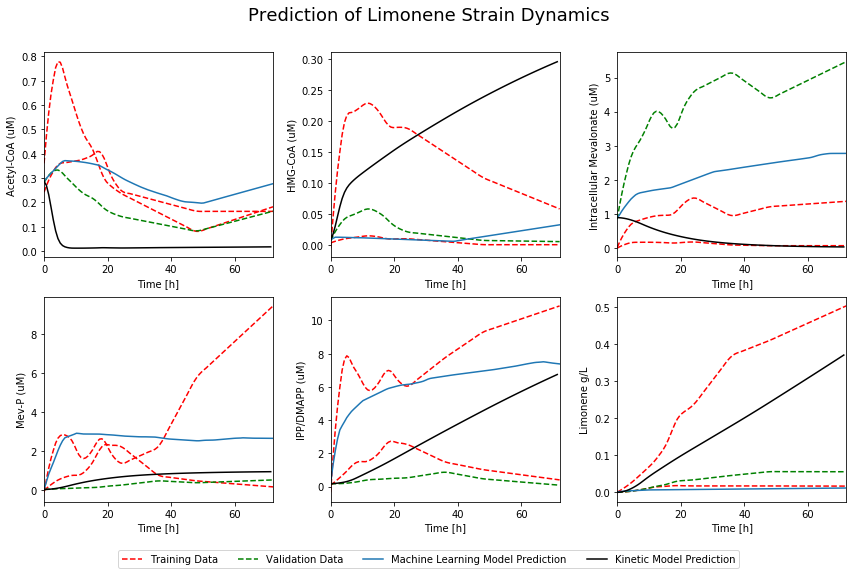

In [19]:
## Create and define the differential equation

# initial conditions
y0 = test_df[targets].iloc[0].tolist()
print('Initial conditions: ',y0)
times = test_tsdf.reset_index()['Time (h)'].tolist()

g = mlode(modelDict, test_tsdf, targets, specific_features) #derivative of concentration wrt time
fit = odeintz(g, y0, times) #integrate g with initial conditions y0
fitT = list(map(list, zip(*fit)))
        
real_vs_predicted = {}
plt.figure(figsize=(12,8))
for i,target in enumerate(targets):
    
    plt.subplot(2,3,i+1)

    #Plot the two high and low strains
    for strain in training_strains:
        strain_df = train_df.loc[(strain,slice(None))]
    
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        trainInterpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(trainInterpFun(times), 9, 2)
        train_line, = plt.plot(times, actual_data,'r--')
    
    for strain in test_strains:
        strain_df = test_df.loc[strain, slice(None)]
        X, y = strain_df.reset_index()['Hour'].tolist(), strain_df[target].tolist()
        interpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(interpFun(times), 9, 2)
        test_line, = plt.plot(times, actual_data,'g--')
    
    pos_pred = [max(fitT[i][j], 0) for j,t in enumerate(times)]
    prediction_line, = plt.plot(times,pos_pred)
    kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times[:-1])]
    kinetic_line, = plt.plot(times[:-1],kinetic_pred,color='k')

    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])

    #Create variable for processing error residuals
    real_vs_predicted[target] = [times,actual_data,pos_pred]
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Prediction of Limonene Strain Dynamics', fontsize=18)
plt.figlegend( (train_line,test_line,prediction_line,kinetic_line), ('Training Data','Validation Data','Machine Learning Model Prediction', 'Kinetic Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
plt.savefig('figures/limonene_prediction.eps', format='eps', dpi=600)
plt.show()

In [20]:
mlmodel = RandomForestRegressor(n_estimators=10)
modelDict = {}

average_training_score = 0
n = 0
for target_index in train_tsdf.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print("Processing target: ", target)

    X = train_tsdf['feature'].values.tolist()
    y = train_tsdf[target_index].values.tolist()
    
    modelDict[target] = clone(mlmodel)
    modelDict[target] = modelDict[target].fit(X,y)
    
    score = modelDict[target].score(X,y)
    print('Cross Validated Pearson R: {:f}'.format(score))
    average_training_score +=  score
    
average_training_score /= n
print('Average Training Score:',average_training_score)

Processing target:  Acetyl-CoA (uM)
Cross Validated Pearson R: 0.972254
Processing target:  HMG-CoA (uM)
Cross Validated Pearson R: 0.988579
Processing target:  Intracellular Mevalonate (uM)
Cross Validated Pearson R: 0.967692
Processing target:  Mev-P (uM)
Cross Validated Pearson R: 0.968513
Processing target:  IPP/DMAPP (uM)
Cross Validated Pearson R: 0.930122
Processing target:  Limonene g/L
Cross Validated Pearson R: 0.993986
Average Training Score: 0.9701910860102986


Initial conditions:  [0.286359015, 0.007628361, 0.892762772, 0.046703445, 0.173320815, 0.0]


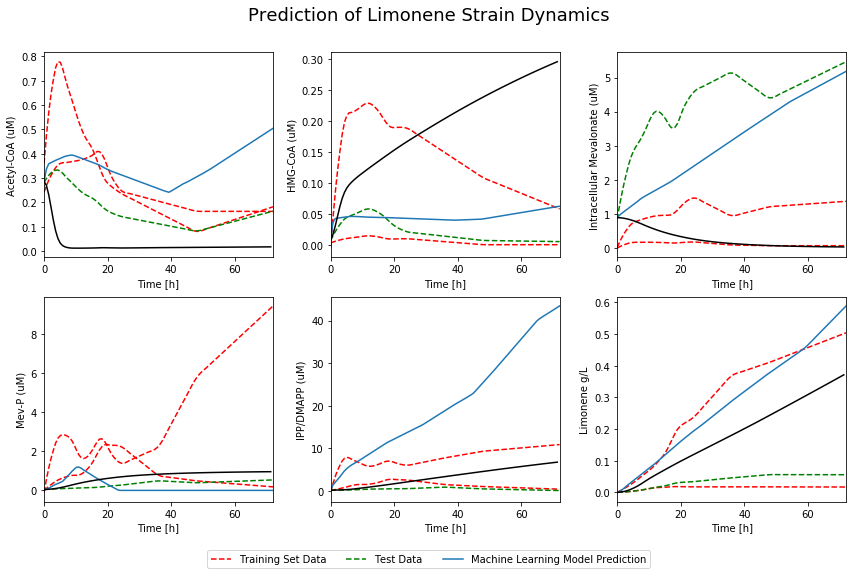

In [21]:
## Create and define the differential equation

# initial conditions
y0 = test_df[targets].iloc[0].tolist()
print('Initial conditions: ',y0)
times = test_tsdf.reset_index()['Time (h)'].tolist()

g = mlode(modelDict, test_tsdf, targets, features) #derivative of concentration wrt time
fit = odeintz(g, y0, times) #integrate g with initial conditions y0
fitT = list(map(list, zip(*fit)))
        
real_vs_predicted = {}
plt.figure(figsize=(12,8))
for i,target in enumerate(targets):
    
    plt.subplot(2,3,i+1)

    #Plot the two high and low strains
    for strain in training_strains:
        strain_df = train_df.loc[(strain,slice(None))]
    
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        trainInterpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(trainInterpFun(times), 9, 2)
        train_line, = plt.plot(times, actual_data,'r--')
    
    for strain in test_strains:
        strain_df = test_df.loc[strain, slice(None)]
        X, y = strain_df.reset_index()['Hour'].tolist(), strain_df[target].tolist()
        interpFun = interp1d(X,y) #create an interpolation function
        actual_data = savgol_filter(interpFun(times), 9, 2)
        test_line, = plt.plot(times, actual_data,'g--')
    
    pos_pred = [max(fitT[i][j], 0) for j,t in enumerate(times)]
    prediction_line, = plt.plot(times,pos_pred)
    kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times[:-1])]
    kinetic_line, = plt.plot(times[:-1],kinetic_pred,color='k')

    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])

    #Create variable for processing error residuals
    real_vs_predicted[target] = [times,actual_data,pos_pred]
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Prediction of Limonene Strain Dynamics', fontsize=18)
plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
plt.savefig('figures/limonene_prediction.eps', format='eps', dpi=600)
plt.show()